In [1]:
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%matplotlib inline

In [2]:
house_df = pd.read_csv(r'House\train.csv')
test_df = pd.read_csv(r'House\test.csv')

In [4]:
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
all_data = pd.concat((house_df.loc[:, 'MSSubClass':'SaleCondition'], 
                     test_df.loc[:, 'MSSubClass':'SaleCondition']))

# data processing

Step1. transform skewed numeric features by talke log(feature+1) -- to make the feature more normal

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000006BA4A58>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000B0792B0>]], dtype=object)

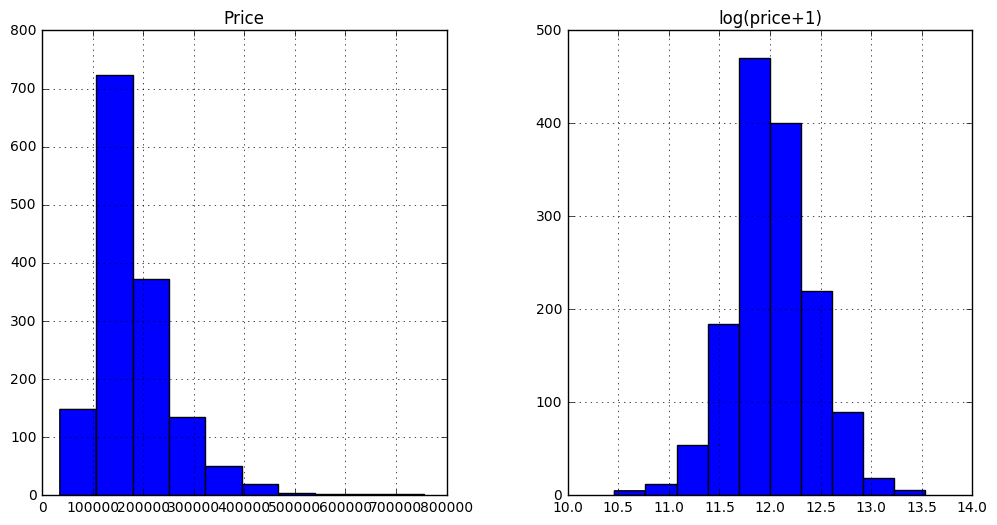

In [12]:
matplotlib.rcParams['figure.figsize'] = (12, 6)
prices = pd.DataFrame({'Price': house_df['SalePrice'], 
                      'log(price+1)': np.log1p(house_df['SalePrice'])})
prices.hist()

In [14]:
# log transform the target:

house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

In [27]:
# log transform skewed numeric feature
numeric_features = all_data.dtypes[all_data.dtypes != object].index
skewed_feats = all_data[numeric_features].apply(lambda x: skew(x.dropna()))  # compute skewness
skewed_feats = skewed_feats[skewed_feats > .75]
skewed_feats = skewed_feats.index
skewed_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [28]:
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [45]:
def find_missing():
    missing = all_data.columns[all_data.isnull().any()].tolist()
    return missing

all_data[find_missing()].isnull().sum()

def count_value(column):
    return all_data[column].value_counts()

def filling_missing_value(column, new_value):
    all_data.loc[all_data[column].isnull(), column] = new_value
    

In [46]:
# filling in numeric missing values
for feat in numeric_features:
    feat_median = all_data[feat].median()
    #print (feat_median)
    filling_missing_value(feat, feat_median)

In [47]:
# filling missing values in training data
# categorical features were filled in using mode value
categorical_feats = all_data.dtypes[all_data.dtypes == "object"].index
for cate in categorical_feats:
    feat_max = np.argmax(count_value(cate))
    #print (cate, '--- ', feat_max)
    filling_missing_value(cate, feat_max)

In [51]:
all_data[find_missing()].isnull().sum()

Series([], dtype: float64)

In [52]:
all_data = pd.get_dummies(all_data)
all_data.shape

(2919, 288)

In [53]:
# creating matrics for sklearn
X_train = all_data[:house_df.shape[0]]
X_test = all_data[house_df.shape[0]:]
y = house_df.SalePrice

In [55]:
print (X_train.shape, X_test.shape, y.shape)

(1460, 288) (1459, 288) (1460,)


# Models and Predictions

In [57]:
# Linear regression: Ridge, Lasso and ElasticNet

In [58]:
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, ElasticNet, LassoLarsCV
from sklearn.cross_validation import cross_val_score

In [64]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring='mean_squared_error', cv=5))
    return rmse

In [65]:
# Ridge Regession
model_ridge = Ridge()

In [66]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]
cv_ridge

[0.13797563787725878,
 0.13702731136448781,
 0.13455388235758986,
 0.1310641019606614,
 0.12846235075005152,
 0.12768170715743515,
 0.1272222705810811,
 0.12740164403490345,
 0.12880944993095433,
 0.13092347915779023,
 0.13328713717102689]

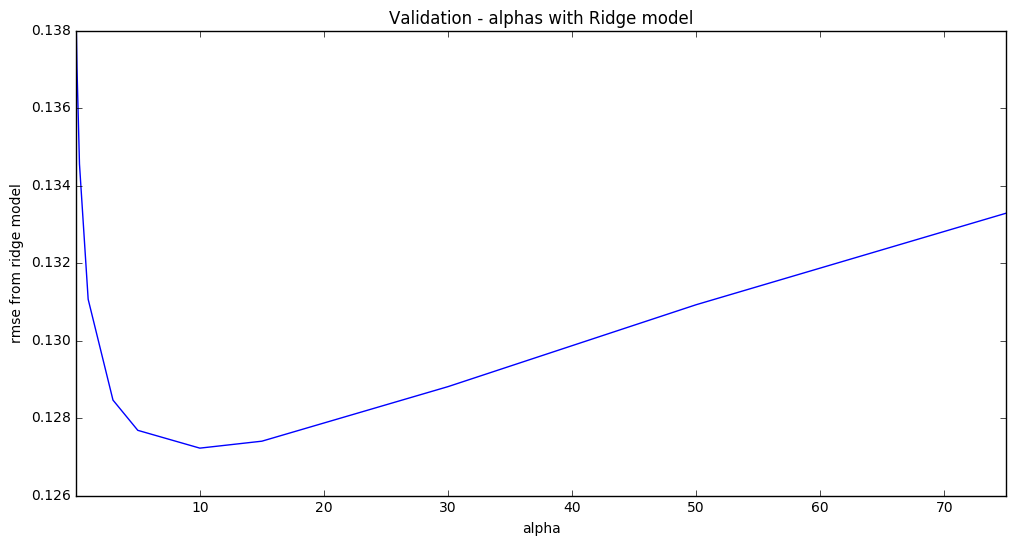

In [69]:
cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot(title='Validation - alphas with Ridge model')
plt.xlabel('alpha')
plt.ylabel('rmse from ridge model')
# from the plot, it looks the minimum rmse is around 0.127 with alpha = 10

In [78]:
ridge_score = cv_ridge.min()
alpha_index = cv_ridge.argmin()
print ('the best rmse for ridge regerssion is %.2f with alpha value 10' %ridge_score)

the best rmse for ridge regerssion is 0.13 with alpha value 10


In [85]:
# Lasso Regression
alphas = [1, 0.1, 0.001, 0.0001, 0.0005]
model_lasso = LassoCV(alphas = alphas).fit(X_train, y)

In [88]:
cv_lasso = rmse_cv(model_lasso)
cv_lasso = cv_lasso.mean()

In [89]:
cv_lasso

0.12326837297201307

In [110]:
# ElasticNet Regression
alphas = [0.05, 0.001, 0.0001, 0.0005]
l1_ratio = 0.7

In [144]:
model_elastic = ElasticNet()

In [145]:
cv_elastic = [rmse_cv(ElasticNet(alpha=alpha)).mean() for alpha in alphas]
cv_elastic

C:\Users\yluo12\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


[0.176077085551712,
 0.12292760983071949,
 0.13131963109904835,
 0.1239973770540809]

In [146]:
cv_elastic = pd.Series(cv_elastic, index=alphas)
# it shows the combination of Ridge and Lasso will get better results

In [147]:
print (cv_elastic.argmin(), cv_elastic.min())

0.001 0.122927609831


In [155]:
elastic_model = ElasticNet(alpha=0.001, l1_ratio=0.7)
elastic_model

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.7,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [156]:
elastic_model.fit(X_train, y)

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.7,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [157]:
elastic_preds = elastic_model.predict(X_test)

# study a little bit more on Lasso regression

In [116]:
# Lasso performs even better than Ridge becasue Lasso is not only doing coefficient shrinkage 
# but also doing feature selection

In [117]:
# coefficients:
coef = pd.Series(model_lasso.coef_, index=X_train.columns)

In [119]:
print ('Lasso picked features: ' + str(sum(coef!=0)) + ' features and eliminated the other ' 
       + str(sum(coef == 0)) + ' features.')

Lasso picked features: 112 features and eliminated the other 176 features.


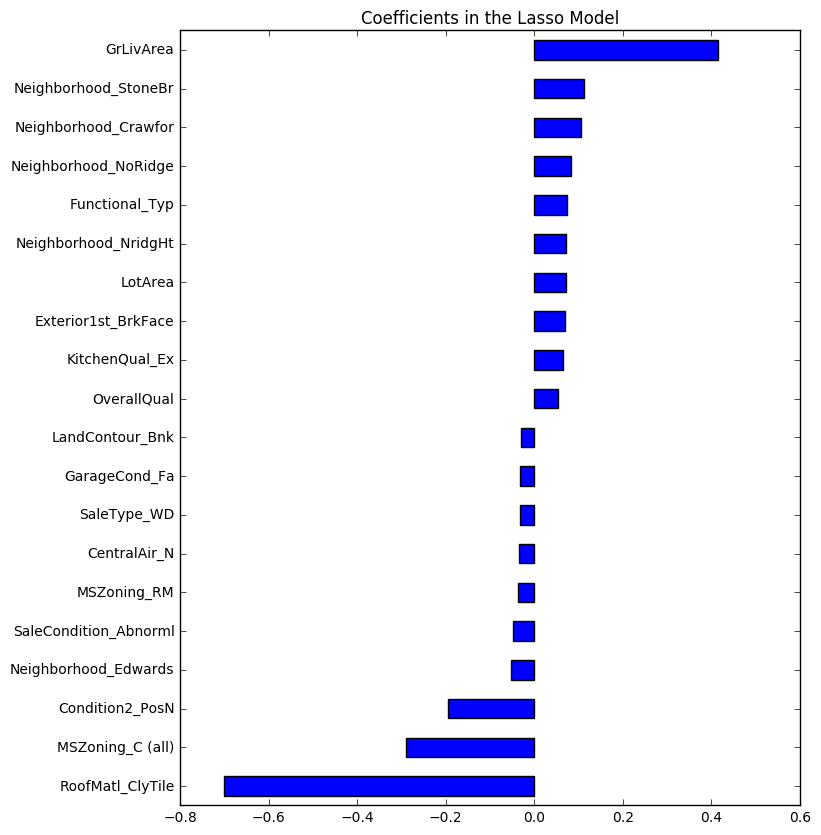

In [121]:
principal_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8, 10)
principal_coef.plot(kind='barh')
plt.title('Coefficients in the Lasso Model')
                

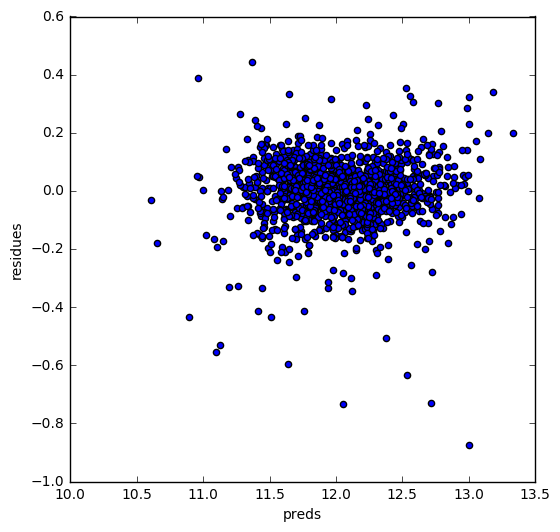

In [123]:
# residule plot
matplotlib.rcParams['figure.figsize'] = (6, 6)
preds = pd.DataFrame({'preds': model_lasso.predict(X_train), 'true': y})
preds['residues'] = preds['true'] - preds['preds']
preds.plot(x='preds', y='residues', kind='scatter')


# Ensemble Boosting method

In [133]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation

In [138]:
seed = 7

In [139]:
kfold = cross_validation.KFold(X_train.shape[0], n_folds = 10, random_state=seed)

In [140]:
params = {'n_estimators': 500, 'max_depth': 2, 'min_samples_split': 2, 'learning_rate': 0.01, 
          'loss': 'ls', 'random_state': seed}
num_trees = 500
model = GradientBoostingRegressor(**params)
results = cross_validation.cross_val_score(model, X_train, y, cv=kfold)
print (results.mean()) 

0.865795686255


In [160]:
model2 = ElasticNet(alpha=0.001)
result2 = cross_validation.cross_val_score(model2, X_train, y, cv=kfold)
print (result2.mean())

0.902874251577


In [158]:
# the above shows ElasticNet model generates good predictions

In [161]:
clf = ElasticNet(alpha=0.001, l1_ratio=0.7)

In [162]:
clf.fit(X_train, y)
elastic_preds = clf.predict(X_test)

In [164]:
clf2 = GradientBoostingRegressor(**params)
clf2.fit(X_train, y)
gbr_preds = clf2.predict(X_test)

In [165]:
preds = 0.7*elastic_preds + 0.3*gbr_preds

In [167]:
solution = pd.DataFrame({'id': test_df['Id'], 'SalePrice': np.exp(preds)})
solution.to_csv(r'C:\Users\yluo12\Desktop\LearningTree\Kaggle\House\house_prediction.csv', index=False)